In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from astropy.cosmology import Planck18 as cosmo
#from astropy.coordinates import SkyCoord, Distance
#import astropy.units as u
from astropy.io.fits import writeto
from scipy.interpolate import InterpolatedUnivariateSpline
import fitsio
import h5py
from scipy.integrate import quad
from tqdm import tqdm

import nbodykit.cosmology as cosmology
from nbodykit.source.catalog import ArrayCatalog, FITSCatalog, HDFCatalog
from nbodykit.transform import SkyToCartesian, StackColumns, CartesianToSky

### Simplest option possible - only redshift cuts

In [2]:
#z_bounds = [0.2, 0.4, 0.6]

z_bounds = [[0.2, 0.4],
            [0.2, 0.4],
            [0.4, 0.6],
            [0.4, 0.6]]
#target_nz = 3e-4 # (h/Mpc)^3
target_nz = np.array([0.00411, 0.000501,
                      0.0129, 0.00535]) * 0.7**3
#target_nz = (0.00857+0.00282+0.00362) * 0.7**3 # 1/(1+sigma_z) = 0.03

In [3]:
# def get_shell_volume(z_lo, z_hi):
#     #cosmo=cosmology.LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
#     #d_lo = cosmo.comoving_distance(z_lo)
#     #d_hi = cosmo.comoving_distance(z_hi)
#     d_lo = Distance(unit=u.Mpc, z = z_lo, cosmology = cosmo)
#     d_hi = Distance(unit=u.Mpc, z = z_hi, cosmology = cosmo)

#     V = (4./3.)*np.pi * (d_hi**3 - d_lo**3)
#     return V

def get_shell_volume(min_z, max_z, cosmo):
    dummy_dict = np.empty(1, dtype=[("ra", "f4"), ("dec", "f4"), ("min_z", "f4"), ("max_z", "f4")])
    dummy_dict["ra"] = 0.; dummy_dict["dec"] = 0.; dummy_dict["min_z"] = min_z; dummy_dict["max_z"] = max_z
    dummy_cat = ArrayCatalog(dummy_dict)
    
    #min_d = quad(integrand, 0, min_z)[0]
    position = (SkyToCartesian(dummy_cat["ra"], dummy_cat["dec"], dummy_cat["min_z"],degrees=True, cosmo=cosmo)).compute()
    min_d = np.sqrt(position[0,0]**2 + position[0,1]**2 + position[0,2]**2)

    position = (SkyToCartesian(dummy_cat["ra"], dummy_cat["dec"], dummy_cat["max_z"],degrees=True, cosmo=cosmo)).compute()
    max_d = np.sqrt(position[0,0]**2 + position[0,1]**2 + position[0,2]**2)
    print(min_d, max_d)
    return abs(4./3. * np.pi * (max_d**3 - min_d**3))

def get_dVolume_dz(z_bins, cosmo):
    dummy_dict = np.empty(len(z_bins), dtype=[("ra", "f4"), ("dec", "f4"), ("z", "f4")])
    dummy_dict["ra"] = np.zeros(len(z_bins)); dummy_dict["dec"] = np.zeros(len(z_bins)); dummy_dict["z"] = z_bins
    dummy_cat = ArrayCatalog(dummy_dict)

    # this outputs positions in Mpc/h
    position = (SkyToCartesian(dummy_cat["ra"], dummy_cat["dec"], dummy_cat["z"],degrees=True, cosmo=cosmo)).compute()
    d = np.sqrt(position[:,0]**2 + position[:,1]**2 + position[:,2]**2)
    dV = np.zeros(len(d)-1)
    
    for i in range(len(dV)):
        dV[i] = 4./3. * np.pi * (d[i+1]**3 - d[i]**3)
    return dV

def calculate_nz(redshifts, bins, cosmo):
    nbar, z_edges = np.histogram(redshifts, bins=bins) # Gives N = n*V
    dV_dz = get_dVolume_dz(z_edges, cosmo)
    
    nbar = nbar / dV_dz
    z_centers = np.zeros(len(nbar))
    for i in range(len(z_centers)):
        z_centers[i] = (z_edges[i] + z_edges[i+1]) / 2.
    
    # finally, interpolate
    nbar_func = InterpolatedUnivariateSpline(z_centers, nbar)
    return nbar_func(redshifts)

def get_total_galaxies(target_nz, z_lo, z_hi, cosmo):
    bins = np.linspace(z_lo, z_hi, 50)
    dV_dz = get_dVolume_dz(bins, cosmo)
    N_galaxies = np.sum(target_nz * dV_dz)
    return N_galaxies

In [11]:
cosmo_nbodykit = cosmology.Cosmology(h=0.7).match(Omega0_m=0.30964)#, Omega0_b=0.04897)

V1 = get_shell_volume(z_bounds[0][0], z_bounds[0][1], cosmo_nbodykit)
V2 = get_shell_volume(z_bounds[2][0], z_bounds[2][1], cosmo_nbodykit)
N_galaxies = np.array([int((V1 * target_nz[0])), int((V1 * target_nz[1])),
                       int((V2 * target_nz[2])), int((V2 * target_nz[3]))])

print("[{:0.0f}, {:0.0f}] galaxies in a volume of {:0.3e} (Mpc/h)^3".format(N_galaxies[0], N_galaxies[1], V1))
print("[{:0.0f}, {:0.0f}] galaxies in a volume of {:0.3e} (Mpc/h)^3".format(N_galaxies[2], N_galaxies[3], V2))
# N_galaxies - get_total_galaxies(target_nz, z_lo, z_hi, cosmo_nbodykit)
# print("{:0.0f} galaxies in a volume of {:0.3e} (Mpc/h)^3".format(N_galaxies, V))
#print(Distance(unit=u.Mpc, z = z_lo, cosmology = cosmo))

570.8853227158975 1083.0868346334407
1083.0868346334407 1538.4096284683512
[6403964, 780629] galaxies in a volume of 4.543e+09 (Mpc/h)^3
[43933624, 18220534] galaxies in a volume of 9.929e+09 (Mpc/h)^3


In [12]:
# NOTE: This function creates a totally uniform random catalog in real-space
# Eventually, we'll want to create randoms based on some redshift distribution, but this is an ok place to start
def create_survey_randoms(num_galaxies, z_lo, z_hi, cosmo):
    
    random = np.zeros((int(num_galaxies), 3))
    pbar = tqdm(total = int(num_galaxies))
    
    dummy_dict = np.empty(1, dtype=[("ra", "f4"), ("dec", "f4"), ("min_z", "f4"), ("max_z", "f4")])
    dummy_dict["ra"] = 0.; dummy_dict["dec"] = 0.; dummy_dict["min_z"] = z_lo; dummy_dict["max_z"] = z_hi
    dummy_cat = ArrayCatalog(dummy_dict)

    #min_d = quad(integrand, 0, min_z)[0]
    position = (SkyToCartesian(dummy_cat["ra"], dummy_cat["dec"], dummy_cat["min_z"],degrees=True, cosmo=cosmo)).compute()
    min_d = np.sqrt(position[0,0]**2 + position[0,1]**2 + position[0,2]**2)

    position = (SkyToCartesian(dummy_cat["ra"], dummy_cat["dec"], dummy_cat["max_z"],degrees=True, cosmo=cosmo)).compute()
    max_d = np.sqrt(position[0,0]**2 + position[0,1]**2 + position[0,2]**2)
    print(min_d, max_d)
    i = 0
    pbar = tqdm(total = int(num_galaxies), position=0, leave=True)
    while i < int(num_galaxies):
        random_pos = np.vstack((
            np.random.uniform(-1*max_d, max_d, 1),
            np.random.uniform(-1*max_d, max_d, 1),
            np.random.uniform(-1*max_d, max_d, 1)
        )).T
        d = np.linalg.norm(random_pos)
        if d > min_d and d < max_d:
            random[i,:] = random_pos
            i = i+1
            pbar.update(1)
    pbar.close()
    
    random_dict=np.empty(len(random),dtype=[('x',random.dtype),('y',random.dtype),('z',random.dtype)])
    random_dict['x']=random[:,0]
    random_dict['y']=random[:,1]
    random_dict['z']=random[:,2]

    random = ArrayCatalog(random_dict)
    random["Position"] = StackColumns((random["x"], random["y"], random["z"]))
    random["RA"], random["DEC"], random["Z"] = CartesianToSky(random["Position"], cosmo_nbodykit)

    random["NZ"] = calculate_nz(random["Z"].compute(), np.linspace(z_lo, z_hi, 50), cosmo_nbodykit)
    random["WEIGHT_FKP"] = 1. / (1 + random["NZ"] * 1e4)
    return random

In [13]:
alpha = 1.
randoms_list = []
for idx in range(len(N_galaxies)):
    randoms_list.append(create_survey_randoms(N_galaxies[idx]*alpha, z_bounds[idx][0], z_bounds[idx][1], cosmo_nbodykit))

  0%|                                               | 0/6403964 [00:00<?, ?it/s]

570.8853227158975 1083.0868346334407


  0%|                                                | 0/780629 [00:00<?, ?it/s]

570.8853227158975 1083.0868346334407


  0%|                                              | 0/43933624 [00:00<?, ?it/s]

1083.0868346334407 1538.4096284683512


  0%|                                              | 0/18220534 [00:00<?, ?it/s]

1083.0868346334407 1538.4096284683512


100%|████████████████████████████| 18220534/18220534 [10:09<00:00, 29884.61it/s]


Text(0, 0.5, 'n(z) $(h/Mpc)^3$')

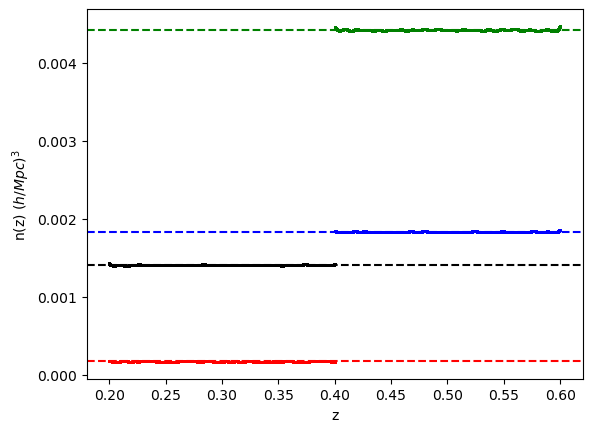

In [14]:
#plt.scatter(random["x"][:5000], random["y"][:5000], s=1, c="black")
#plt.gca().set_aspect('equal')
#plt.hist(random["X"][:1000], bins=100)

# n_of_z, bin_edges = np.histogram(random["NZ"].compute(), bins=50)
# bins = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure()
#plt.plot(bins, n_of_z)
plt.scatter(randoms_list[0]["Z"].compute(), randoms_list[0]["NZ"].compute(), s=1, c="black")
plt.scatter(randoms_list[1]["Z"].compute(), randoms_list[1]["NZ"].compute(), s=1, c="red")
plt.scatter(randoms_list[2]["Z"].compute(), randoms_list[2]["NZ"].compute(), s=1, c="green")
plt.scatter(randoms_list[3]["Z"].compute(), randoms_list[3]["NZ"].compute(), s=1, c="blue")
plt.axhline(target_nz[0], c="black", ls="--")
plt.axhline(target_nz[1], c="red", ls="--")
plt.axhline(target_nz[2], c="green", ls="--")
plt.axhline(target_nz[3], c="blue", ls="--")
plt.xlabel("z")
plt.ylabel(r"n(z) $(h/Mpc)^3$")

In [17]:
# fitsio.write("data/random_for_Robin.fits", {"RA": random["RA"].compute(), 
#                                                  "DEC" : random["DEC"].compute(), 
#                                                  "Z": random["Z"].compute(),
#                                                  "NZ": random["NZ"].compute(),
#                                                  "WEIGHT_FKP": random["WEIGHT_FKP"].compute()})

# write to a HDF5 file
labels = ["0_0", "1_0", "0_1", "1_1"]
for i in range(len(randoms_list)):
    with h5py.File("data/input_data/emulator/random_"+labels[i]+".h5", 'w') as ff:
        ff.create_dataset("position_x", data=randoms_list[i]["x"].compute())
        ff.create_dataset("position_y", data=randoms_list[i]["y"].compute())
        ff.create_dataset("position_z", data=randoms_list[i]["z"].compute())
        ff.create_dataset("fkp_weights", data=randoms_list[i]["WEIGHT_FKP"].compute())

In [36]:
#random_test = FITSCatalog("random_sample_2_redshift_2.fits")
random_test = HDFCatalog("data/input_data/random_for_Robin.hdf5")

print(random_test)
print("columns = ", random_test.columns) # default Weight,Selection also present
print("total size = ", random_test.csize)

print(random_test["Weight"].compute())

HDFCatalog(size=2640660, FileStack(HDFFile(path=/home/joeadamo/Research/SPHEREx/covapt_mt/data/random_for_Robin.hdf5, dataset=/, ncolumns=5, shape=(2640660,)>, ... 1 files))
columns =  ['DEC', 'NZ', 'RA', 'Selection', 'Value', 'WEIGHT_FKP', 'Weight', 'Z']
total size =  2640660
[1. 1. 1. ... 1. 1. 1.]


In [19]:
# Save the k array
#k = np.array([0.00694, 0.01482, 0.0227, 0.03058, 0.03846, 0.04634, 0.05422, 0.0621, 0.06998,
#              0.07786, 0.08574, 0.09362, 0.1015,  0.10938, 0.11726, 0.12514, 0.13302, 0.1409,
#              0.14878, 0.15666, 0.16454, 0.17242, 0.1803,  0.18818, 0.19606])
k = np.linspace(0.002, 0.2, 26)
k_centers = (k[:-1] + k[1:]) / 2
print(k_centers)
np.savez("data/input_data/emulator/kbins.npz", k=k_centers)

[0.00596 0.01388 0.0218  0.02972 0.03764 0.04556 0.05348 0.0614  0.06932
 0.07724 0.08516 0.09308 0.101   0.10892 0.11684 0.12476 0.13268 0.1406
 0.14852 0.15644 0.16436 0.17228 0.1802  0.18812 0.19604]
